In [1]:
import os
import requests
import random
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from citipy import citipy
from geopy.geocoders import Nominatim
from config import WOM_API_KEY

class WeatherPy(object):
    
    _number_of_cities = None
    _cities_set = set()
    _cities_df = pd.DataFrame()
    _log_file = None
    _csv_file = None
    _png_file = None
    _actual_png_file = None
    _geolocator = Nominatim()
    _base_url = 'http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=' + WOM_API_KEY + '&q='
    _today = date.today().strftime('%m/%d/%y')
    
    @property
    def cities(self):
        return self._cities_df.reset_index()[[
            'City Name', 'Country Code', 'Date',
            'Latitude', 'Longitude', 'Actual Latitude', 'Actual Longitude',
            'Humidity', 'Max Temperature', 'Cloudiness', 'Wind Speed'
        ]]

    @property
    def number_of_cities(self):
        return self._number_of_cities
      
    def __init__(self, 
                 number_of_cities=None,
                 log_file=None,
                 csv_file=None,
                 png_file=None,
                 actual_png_file=None):
        self._number_of_cities = number_of_cities or 4 # Default to 4 for testing
        self._png_file = png_file
        self._actual_png_file = actual_png_file
        self._csv_file = csv_file
        if log_file:
            self._log_file = open(log_file, 'w')
        sns.set()
        sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
        
    def __del__(self):
        if self._log_file:
            self._log_file.close()

    def _pick_a_city(self, i):
        while True:
            lat, lon = (random.uniform(-90, 90), random.uniform(-180, 180))
            city = citipy.nearest_city(lat, lon)
            city_name = city.city_name
            country_code = city.country_code
            city_full = city_name + ',' + city.country_code

            self.log('Processing City # {} | {}'.format(i, city_full))

            # Check if city is already picked
            if city_full in self._cities_set:
                self.log('Skip duplicate {}'.format(city_full))
                continue
            
            # Get actual location of the city.
            location = self._geolocator.geocode(city_full)
            if location:                                    
                actual_lat = location.latitude
                actual_lon = location.longitude
                                            
            #g = geocoder.google(city_full)
            #if g:
            #    (actual_lat, actual_lon) = g.latlng
            else:
                self.log('Unable to get actual location of the city {}. Skip.'.format(city_full))
                continue
                
            # Check weather
            url = self._base_url + city_full
            self.log(url)
            response = requests.get(url)
            if response.status_code != 200:
                self.log('Weather not found for ' + city_full + '. Try another city.')
                continue

            w = response.json()   
            self._cities_df = self._cities_df.append(
                pd.DataFrame([{
                        'City Name': city_name,
                        'Country Code': country_code,
                        'Date': self._today,
                        'Latitude': lat,
                        'Longitude': lon,
                        'Actual Latitude': actual_lat,
                        'Actual Longitude': actual_lon,
                        'Humidity': w['main']['humidity'],
                        'Max Temperature': w['main']['temp_max'],
                        'Wind Speed': w['wind']['speed'],
                        'Cloudiness': w['clouds']['all'],
                    }]
                )
            )

            self._cities_set.add(city_full)
            break
        
    def pick_all_cities(self):
        for i in range(self.number_of_cities):
            self._pick_a_city(i)
        
    def write_data_to_csv(self, csv_file=None):
        csv_file = csv_file or self._csv_file
        self.cities.to_csv(csv_file)
        
    def plot_lat_lon(self, use_actual=False):
        fig, ax = plt.subplots(figsize=(10, 5))
        if use_actual:
            self.cities.plot.scatter('Actual Longitude', 'Actual Latitude',  ax=ax)
        else:
            self.cities.plot.scatter('Longitude', 'Latitude', ax=ax)
            
        plt.xlim(-180, 180); plt.ylim(-90, 90)
        plt.show()
        
    def plot_weather(self, use_actual=False):
        fig = plt.figure(figsize=(15,10))
        fig.suptitle("Correlation of City Latitude vs. Weather Metrics")

        x = 'Actual Latitude' if use_actual else 'Latitude'
        for i, metric in [(1, 'Max Temperature'),
                          (2, 'Humidity'),
                          (3, 'Cloudiness'),
                          (4, 'Wind Speed')]:
            self.cities.plot.scatter(x=x, y=metric, 
                                   title='City Latitude vs. {} ({})'.format(metric, self._today),
                                   ax=plt.subplot(2, 2, i),
                                   xlim=(-90, 90))                          

        if use_actual and self._actual_png_file:
            print('save actual png')
            fig.savefig(self._actual_png_file)
        if not use_actual and self._png_file:
            fig.savefig(self._png_file)
        plt.show()

    def log(self, msg):
        if self._log_file:
            self._log_file.write(msg + '\n')
            self._log_file.flush() # Easier to see progress in tail -f
        else:
            print(msg)

In [2]:
weather_py = WeatherPy(
    number_of_cities=500,
    log_file='weather_py.log',
    csv_file='weather_py.csv',
    png_file='weather_py.png',
    actual_png_file='weather_actual.png',
)
weather_py.pick_all_cities()
weather_py.write_data_to_csv()

In [3]:
weather_py.cities.head()

,City Name,Country Code,Date,Latitude,Longitude,Actual Latitude,Actual Longitude,Humidity,Max Temperature,Cloudiness,Wind Speed
0,carutapera,br,03/11/18,8.251069,-40.611262,-1.201664,-46.020562,86,83.35,32,10.11
1,ushuaia,ar,03/11/18,-88.345452,-52.040169,-54.806933,-68.307325,66,51.80,20,4.59
2,beira,mz,03/11/18,-21.125569,35.654364,-19.828707,34.841782,88,78.80,40,6.76
3,high level,ca,03/11/18,60.269763,-117.642164,58.516667,-117.133333,63,28.40,20,5.82
4,ancud,cl,03/11/18,-41.174507,-82.892929,-41.868195,-73.828751,98,56.89,92,6.38


Using online tool: https://www.latlong.net/, I did some spot checks and found out that the 'actual' location is much better. The final chart will use the 'Actual Latitude' instead of Latitude.

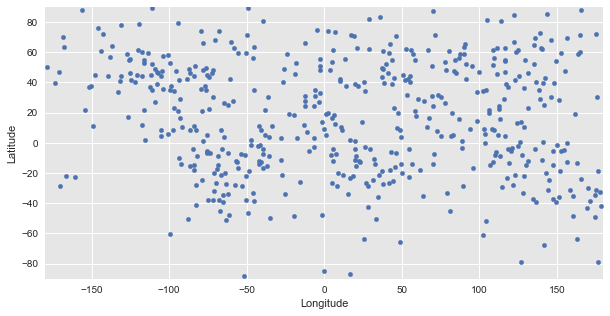

In [4]:
weather_py.plot_lat_lon()

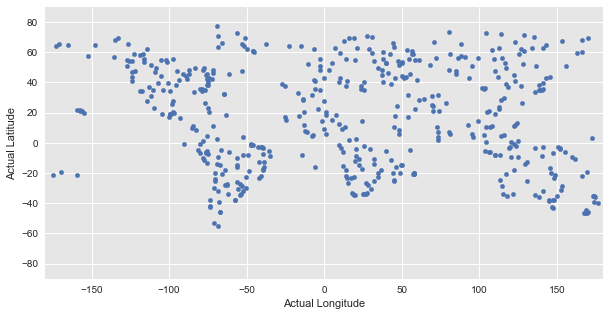

In [5]:
weather_py.plot_lat_lon(use_actual=True)

The 'Actual' coordinates match the map of the world so analysis will based on the scatter plot using the 'Actual' latitude as they are more precise.

save actual png


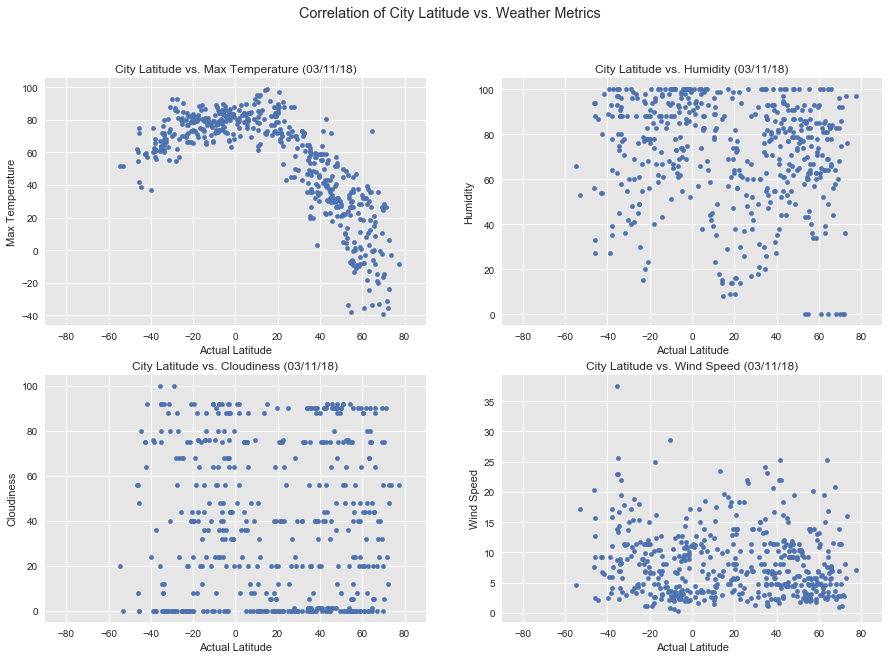

In [7]:
weather_py.plot_weather(use_actual=True)

### Destruct object to clean up

In [10]:
del weather_py